Copyright (c) 2025 Mitsuru Ohno  
Use of this source code is governed by a BSD-3-style  
license that can be found in the LICENSE file.  

## 当ノートブックのワークフロー  
1. 未知の速度定数を含む、csvに書き込んだ反応式を読み込む。  
2. 化学種の濃度の経時変化の実験データを読み込む。実験データには欠損を含んでもよい。  
2. 化学種ごとの微分型の反応速度式を作成する。速度定数が未知の素反応にはシンボリックな変数が割り振られる、  
3. 作成した微分方程式を、数値解析可能な形式にする  
4.  scipy.optimize.minimizeを使い、化学種ごとの濃度の経時変化が、実験値と近づくように、未知の速度定数を求める。  
5. 経時変化を図示する  


## 使用方法の要約
基本的な使用: RxnIVPsolv("sample_data.csv")でインスタンス化  
数値積分: get_ode_system()で必要なオブジェクトを取得    
可視化: matplotlibで結果をプロット  
これらの使用例は、現在のコードが正しく動作することを前提としています。もしエラーが発生した場合は、debug_ode_system()メソッドで詳細な情報を確認できます。  

## 引用文献  
5) Kinetics of Three-compound Equilibrations. II. The Isomerization of Xylene1
Robert H. Allen and Larry D. Yats
Journal of the American Chemical Society 1959 81 (20), 5289-5292
DOI: 10.1021/ja01529a010  
https://doi.org/10.1021/ja01529a010  

- 文献中Table I のデータを用いた。  

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str((Path.cwd() / ".." / "src").resolve()))

## 反応式を記載したcsvファイルを指定する  

In [2]:
file_path_rxn = './sample_data/ref5/sample_rxn_ref5.csv'  # CSVファイルのパスを指定

## 反応速度式をscipy.integrate.solve_ivpで処理できる連立微分方程式にする  

In [3]:
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sympy import Symbol
from sympy.core.symbol import Symbol as SympySymbol
import inspect

from rxnfit.build_ode import RxnODEbuild, create_system_rhs
from rxnfit.solv_ode import SolverConfig, RxnODEsolver
from rxnfit.expdata_reader import expdata_read, get_y0_from_expdata
from rxnfit.expdata_fit_sci import ExpDataFitSci

# 反応速度式の作成

In [4]:
builded_rxnode = RxnODEbuild(file_path_rxn)

In [5]:
builded_rxnode.get_ode_info(debug_info=True)

number of species: 3
unique species: ['oXy', 'pXy', 'mXy']
rate constant: {'k1': k1, 'k2': k2, 'k3': k3, 'k4': k4, 'k5': k5, 'k6': k6}

=== debug info ===
Successfully created function for oXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for pXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for mXy with args: ['t', 'oXy', 'pXy', 'mXy']
order of args: ['t', 'oXy', 'pXy', 'mXy']
system of ODE: {'oXy': '-k1*oXy(t)+k2*pXy(t)-k3*oXy(t)+k4*mXy(t)', 'pXy': 'k1*oXy(t)-k2*pXy(t)-k5*pXy(t)+k6*mXy(t)', 'mXy': 'k3*oXy(t)-k4*mXy(t)+k5*pXy(t)-k6*mXy(t)'}


In [6]:
# 作成した微分方程式
builded_rxnode.get_ode_system()[0]

Successfully created function for oXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for pXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for mXy with args: ['t', 'oXy', 'pXy', 'mXy']


[Eq(Derivative(oXy(t), t), -k1*oXy(t) + k2*pXy(t) - k3*oXy(t) + k4*mXy(t)),
 Eq(Derivative(pXy(t), t), k1*oXy(t) - k2*pXy(t) - k5*pXy(t) + k6*mXy(t)),
 Eq(Derivative(mXy(t), t), k3*oXy(t) - k4*mXy(t) + k5*pXy(t) - k6*mXy(t))]

In [7]:
# 速度定数の確認
print(builded_rxnode.rate_consts_dict)

check_type = [v for v in builded_rxnode.rate_consts_dict.values()]
[type(e) for e in check_type]

{'k1': k1, 'k2': k2, 'k3': k3, 'k4': k4, 'k5': k5, 'k6': k6}


[sympy.core.symbol.Symbol,
 sympy.core.symbol.Symbol,
 sympy.core.symbol.Symbol,
 sympy.core.symbol.Symbol,
 sympy.core.symbol.Symbol,
 sympy.core.symbol.Symbol]

## 経時変化の実験データを読み込み　　
### データフレーム化  

In [8]:
df1 = pd.read_csv(f'./sample_data/ref5/ref5_df1.csv')
df2 = pd.read_csv(f'./sample_data/ref5/ref5_df2.csv')
df3 = pd.read_csv(f'./sample_data/ref5/ref5_df3.csv')
df4 = pd.read_csv(f'./sample_data/ref5/ref5_df4.csv')

expdata_read([df1, df2, df3, df4])  # 複数データフレームのリストを渡すとまとめて読み込み可能

[([array([ 0. ,  0.5,  1. ,  2. ,  3. ,  7. , 20. , 25. , 44. ]),
   array([ 0. ,  0.5,  1. ,  2. ,  3. ,  7. , 20. , 25. , 44. ]),
   array([ 0. ,  0.5,  1. ,  2. ,  3. ,  7. , 20. , 25. , 44. ])],
  [array([0.999, 0.95 , 0.846, 0.738, 0.632, 0.434, 0.19 , 0.175, 0.187]),
   array([0.   , 0.048, 0.148, 0.241, 0.328, 0.478, 0.632, 0.627, 0.602]),
   array([0.001, 0.002, 0.006, 0.021, 0.04 , 0.088, 0.178, 0.198, 0.211])]),
 ([array([ 0,  1,  2,  3,  5,  8, 12, 22, 46]),
   array([ 0,  1,  2,  3,  5,  8, 12, 22, 46]),
   array([ 0,  1,  2,  3,  5,  8, 12, 22, 46])],
  [array([0.005, 0.006, 0.026, 0.02 , 0.046, 0.089, 0.114, 0.144, 0.174]),
   array([0.986, 0.973, 0.933, 0.918, 0.86 , 0.768, 0.709, 0.647, 0.609]),
   array([0.009, 0.021, 0.041, 0.062, 0.094, 0.143, 0.177, 0.209, 0.217])]),
 ([array([ 0. ,  1. ,  1.5,  2.5,  4. ,  8. , 20. , 28. ]),
   array([ 0. ,  1. ,  1.5,  2.5,  4. ,  8. , 20. , 28. ]),
   array([ 0. ,  1. ,  1.5,  2.5,  4. ,  8. , 20. , 28. ])],
  [array([0.001, 0.00

### フィッティング  
ExpDataFitSci でシンボリックな速度定数をフィッティング。  


In [9]:
builded_rxnode = RxnODEbuild(file_path_rxn)
t_range = (float(df1.iloc[:, 0].min()), float(df1.iloc[:, 0].max()))
fit_sci = ExpDataFitSci(builded_rxnode, [df1, df3, df4], t_range)
result, param_info = fit_sci.run_fit(
    p0=[1e-8, 1e-8, 1e-1, 1e-1, 1e-1, 1e-1], # 未知の速度定数の初期値  
    use_log_fit=True, # k1, k2が0に近いと予想されるため、対数変換した値でフィットする  
    lower_bound=1e-10,
)  

Successfully created function for oXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for pXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for mXy with args: ['t', 'oXy', 'pXy', 'mXy']
最適化成功: True
最適化された速度定数:
  k1 = 1e-08
  k2 = 1e-08
  k3 = 0.155383
  k4 = 0.0427401
  k5 = 0.338202
  k6 = 0.116507
残差二乗和: 0.0219276


In [10]:
# フィッティング結果で builded_rxnode を更新し、SolverConfig を取得
# fit_sci.get_fitted_rate_const_dict() と get_solver_config_args() を使用
builded_rxnode.rate_consts_dict.update(fit_sci.get_fitted_rate_const_dict())
config = SolverConfig(**fit_sci.get_solver_config_args())

## 数値積分を実行する  

In [11]:
# 最適化結果および与えたデータから、solve_ivp に渡す引数を作成
# 1. ODE システムと system_rhs を取得（builded_rxnode.rate_consts_dict は上記で更新済み）
ode_construct = builded_rxnode.get_ode_system()
(system_of_equations, sympy_symbol_dict, ode_system,
 function_names, rate_consts_dict) = ode_construct
system_rhs = create_system_rhs(ode_system, function_names)

# 2. 実験データの時間点を t_eval に使用（任意・省略可）
t_eval = np.array(df1.iloc[:, 0].values, dtype=float)

# 3. solve_ivp に渡す引数を構築（config を引き継ぎ、fun と t_eval を追加）
solve_ivp_kwargs = {
    'fun': system_rhs,
    **vars(config),
    't_eval': t_eval,
}

Successfully created function for oXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for pXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for mXy with args: ['t', 'oXy', 'pXy', 'mXy']


In [12]:
# 基本的な数値積分 -インスタンス化-
solved_rxnode = RxnODEsolver(builded_rxnode, config)

In [13]:
ode_construct, sol = solved_rxnode.solve_system()

Successfully created function for oXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for pXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for mXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for oXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for pXy with args: ['t', 'oXy', 'pXy', 'mXy']
Successfully created function for mXy with args: ['t', 'oXy', 'pXy', 'mXy']



=== Time-course plot ===


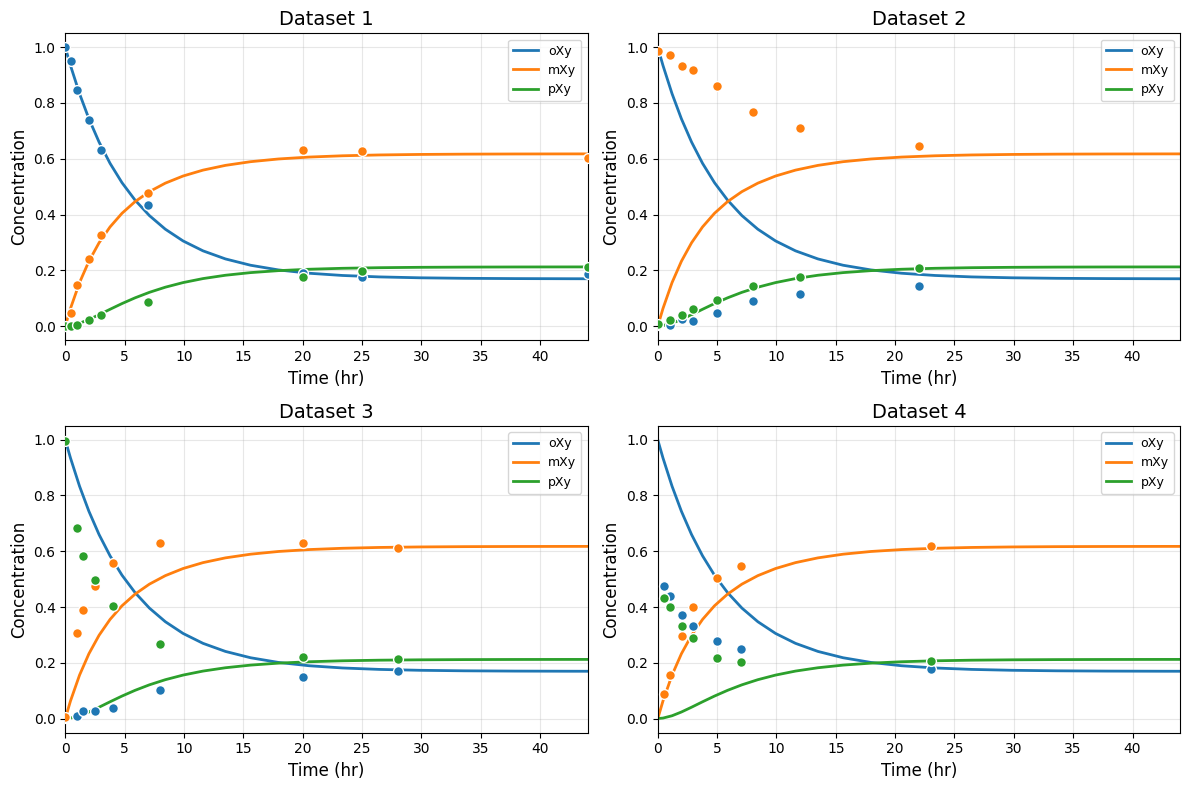


=== Concentration at the final time point ===
oXy: 0.170133
mXy: 0.617285
pXy: 0.212582


In [14]:
# シミュレーション曲線に実験データ点を重ねる（線と点で色を揃える）
solved_rxnode.solution_plot(expdata_df=[df1, df2, df3, df4], species=['oXy', 'mXy', 'pXy'], subplot_layout=(2,2))